In [1]:
import numpy as np
import pickle
import pandas as pd
import re
import warnings
import random
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import re
from nltk.corpus import stopwords
import nltk
from tqdm import tqdm
from collections import defaultdict
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

# Data Modeling

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay 
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, f1_score
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('train.csv')
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
len(data)

7613

In [4]:
nltk.download('stopwords')
all_stopwords = stopwords.words('english')
URL_PATTERN = '((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*'

[nltk_data] Downloading package stopwords to C:\Users\Melis
[nltk_data]     Nur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def process(text):
    '''
    Removes stopwords, url and punctuation.
    '''
    
    remove_stopwords = ' '.join([word for word in text.split() if word not in all_stopwords])
    remove_url = re.sub(URL_PATTERN,'',remove_stopwords)
    remove_punctuation = re.sub(r'[^\w\s]','', remove_url)
    
    return remove_punctuation.lower()

In [6]:
data['cleaned_tweets'] = data['text'].apply(lambda text : process(text))

print(f'Before cleaning:  \n {data.text[50]}')
print(f'after cleaning: \n {data.cleaned_tweets[50]}')

Before cleaning:  
 Deputies: Man shot before Brighton home set ablaze http://t.co/gWNRhMSO8k
after cleaning: 
 deputies man shot brighton home set ablaze 


In [7]:
data.head()

,id,keyword,location,text,target,cleaned_tweets
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked shelter place notified off...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent photo ruby alaska smoke wildfire...


## Corpus and Word Frequency Dictionaries

In [8]:
def word_dictionary(text):
    
    frequency_dict = defaultdict(int)
    
    for word in text.split():
        if word not in frequency_dict:
            frequency_dict[word] = 1
        else:
            frequency_dict[word] += 1
            
    return frequency_dict

In [9]:
positive_tweets = ' '.join(text for text in data[data['target'] == 1]['cleaned_tweets'])
negative_tweets = ' '.join(text for text in data[data['target'] == 0]['cleaned_tweets'])

In [10]:
positive_frequency_dict = word_dictionary(positive_tweets)
negative_frequency_dict = word_dictionary(negative_tweets)

In [11]:
positive_frequency_dict

defaultdict(int,
            {'our': 17,
             'deeds': 1,
             'reason': 7,
             'earthquake': 45,
             'may': 50,
             'allah': 6,
             'forgive': 1,
             'us': 81,
             'forest': 50,
             'fire': 178,
             'near': 47,
             'la': 22,
             'ronge': 1,
             'sask': 1,
             'canada': 8,
             'all': 24,
             'residents': 8,
             'asked': 1,
             'shelter': 6,
             'place': 14,
             'notified': 1,
             'officers': 4,
             'no': 39,
             'evacuation': 40,
             'orders': 9,
             'expected': 11,
             '13000': 4,
             'people': 105,
             'receive': 2,
             'wildfires': 11,
             'california': 111,
             'just': 21,
             'got': 29,
             'sent': 4,
             'photo': 18,
             'ruby': 1,
             'alaska': 5,
             's

In [12]:
def sum_freq_of_tweets(frequency_dict, tweet):
    
    freq = 0 
    
    for word in tweet.split():
        freq += frequency_dict[word]
        
    return freq

In [13]:
data['pos_freq'] = data['cleaned_tweets'].apply(lambda tweet : sum_freq_of_tweets(positive_frequency_dict, tweet))
data['neg_freq'] = data['cleaned_tweets'].apply(lambda tweet : sum_freq_of_tweets(negative_frequency_dict, tweet))

data.head()

,id,keyword,location,text,target,cleaned_tweets,pos_freq,neg_freq
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds reason earthquake may allah forgive us,208,154
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,307,100
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked shelter place notified off...,177,143
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,282,109
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent photo ruby alaska smoke wildfire...,132,226


## Split Data to Train Set and Validation Set

In [14]:
def split_train_test(features, labels, split_size):
    train_size = int(len(features) * split_size)
    
    data = list(zip(features,labels))
    shuffle_data = random.sample(data,len(data))
    
    shuffle_features = [feature for feature,label in shuffle_data]
    shuffle_labels = [label for feature,label in shuffle_data]
    
    x_train = np.array(shuffle_features[:train_size])
    y_train = np.array(shuffle_labels[:train_size]).reshape((len(shuffle_labels[:train_size]),1))
    
    x_test = np.array(shuffle_features[:train_size])
    y_test = np.array(shuffle_labels[:train_size]).reshape((len(shuffle_labels[:train_size]),1))
    
    return x_train, x_test, y_train, y_test

## Implementing Logistic Regression

*Exploring the distribution of frequency features for both class through scatter plot.*

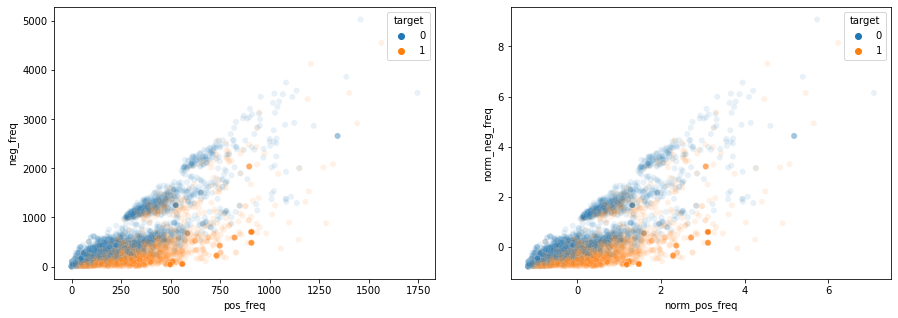

In [15]:
# normalization

data['norm_pos_freq'] = (data['pos_freq'] - data['pos_freq'].mean()) / data['pos_freq'].std()
data['norm_neg_freq'] = (data['neg_freq'] - data['neg_freq'].mean()) / data['neg_freq'].std()

fig, axes = plt.subplots(ncols = 2, figsize=(15,5))
sns.scatterplot(x='pos_freq', y='neg_freq', hue='target', data=data, ax=axes[0], alpha=0.1)

sns.scatterplot(x='norm_pos_freq', y='norm_neg_freq', hue='target', data=data, ax=axes[1], alpha=0.1);

## Custom Logistic Regression

In [16]:
class LogisticRegression:
    
    def __init__(self):
        weight= None
        costs = []
        accuracies = []
        
    def sigmoid(self,x):
        output = 1 / (1 + np.exp(-x))
        
        return output
    
    def compute_cost(self,y_pred, y):
        error = (y * np.log(y_pred) + (1- y) * (1 - np.log(y_pred)))
        
        return -np.mean(error)
    
    def compute_gradient(self, X, y, y_pred):
        gradient = (1 / len(X) * np.dot(X.T, (y_pred - y)))
        
        return gradient
    
    def fit(self, X, y, epoch, learning_rate):
        
        self.weight = np.zeros((X.shape[1],1))  # initialize weight
        
        costs = []
        accuracies = []
        
        for _ in tqdm(range(epoch)):
            
            y_pred = self.sigmoid(np.dot(X, self.weight))
            
            cost = self.compute_cost(y_pred,y)
            gradient = self.compute_gradient(X, y, y_pred)
            
            self.weight -= learning_rate * gradient
            
            accuracy = self.score(X,y)
            
            costs.append(cost)
            accuracies.append(accuracy)
            
        
        self.costs = costs
        self.accuracies = accuracies
        
        
    def predict(self, X):
        y_pred = self.sigmoid(np.dot(X,self.weight))
        
        return y_pred > 0.5
    
    def predict_prob(self,X):
        y_prob = self.sigmoid(np.dot(X, self.weight))
        
        return y_prob
    
    def score(self,X, y):
        y_pred = self.predict(X)
        
        return np.mean(y_pred == y)

In [17]:
EPOCH = 500
LEARNING_RATE = 1

tweets_val = data[['pos_freq','neg_freq']].values

mean = np.mean(tweets_val, axis = 0)
std = np.std(tweets_val, axis = 0)

# normalize feature (x - mean) / sd
tweets_val = (tweets_val - mean) / std
labels = data.copy().pop('target').values

X_train, X_test, y_train, y_test = split_train_test(tweets_val, labels, 0.8)

X_train = np.append(np.ones((X_train.shape[0],1)), X_train, axis = 1)
X_test = np.append(np.ones((X_test.shape[0],1)), X_test, axis = 1)

logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train, EPOCH, LEARNING_RATE)

print(f'Optimized parameters: \n{logistic_reg.weight}')
print(f'Loss: {logistic_reg.costs[-1]}')
print(f'Test Accuracy: {logistic_reg.score(X_test, y_test)}')

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1338.57it/s]

Optimized parameters: 
[[-0.35302227]
 [ 2.07932965]
 [-2.34667191]]
Loss: -1.1275588464051145
Test Accuracy: 0.7423645320197044


Text(0.5, 1.0, 'Accuracy')

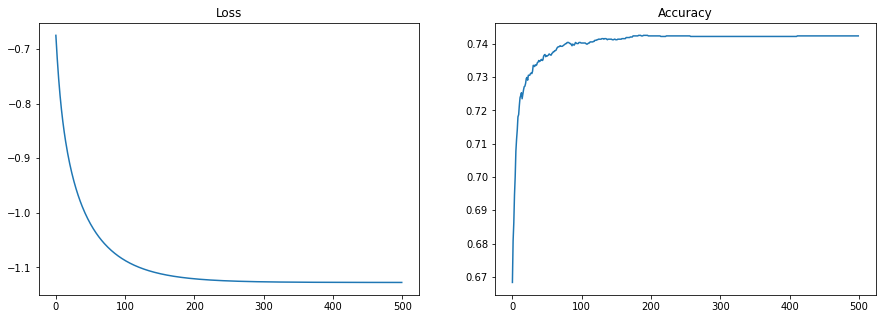

In [18]:
fig, axes = plt.subplots(ncols = 2, figsize=(15,5))

loss_history = logistic_reg.costs
accuracy_history = logistic_reg.accuracies

axes[0].plot(range(EPOCH), loss_history)
axes[0].set_title('Loss')

axes[1].plot(range(EPOCH), accuracy_history)
axes[1].set_title('Accuracy')

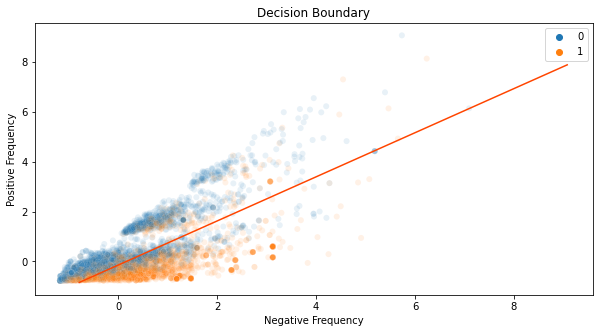

In [19]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(x = 'norm_pos_freq', y = 'norm_neg_freq', hue = 'target', data = data, alpha = 0.1)

ax.legend([1, 0])
ax.set_xlabel('Negative Frequency')
ax.set_ylabel('Positive Frequency')
ax.set_title('Decision Boundary')

x_bound = np.array([np.min(tweets_val[:, 1]), np.max(tweets_val[:, 1])])
y_bound = -(logistic_reg.weight[0] + logistic_reg.weight[1] * x_bound) / logistic_reg.weight[2]

sns.lineplot(x = x_bound, y = y_bound, color = 'orangered');

## Model Evaluation and ROC Curve

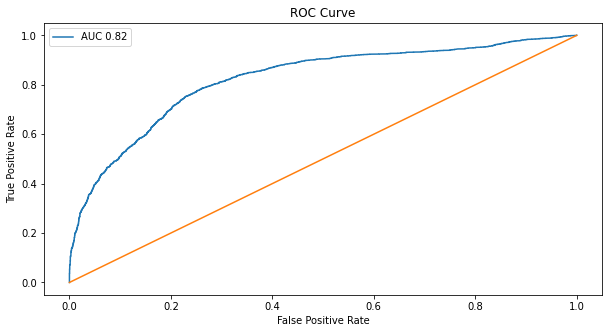

In [20]:
y_prob = logistic_reg.predict_prob(X_train)

fpr, tpr, threshold = roc_curve(y_train,y_prob)
roc_auc = roc_auc_score(y_train,y_prob)

plt.figure(figsize=(10,5))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label = "AUC %.2f" %roc_auc);
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();

In [21]:
y_pred = logistic_reg.predict(X_train)
print("Training F1 Score: ",f1_score(y_train, y_pred))
print("Accuracy score: ", accuracy_score(y_train, y_pred))
print("Confusion matrix: ", confusion_matrix(y_train, y_pred))

Training F1 Score:  0.664385026737968
Accuracy score:  0.7423645320197044
Confusion matrix:  [[2968  523]
 [1046 1553]]
